<a href="https://colab.research.google.com/github/afnank07/Image_Calssification-TransferLearning-/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# Import all the necessary files!
import os
from os import getcwd
import zipfile
import numpy as np
from google.colab import files
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import the inception model 
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Download the .h5 file of InceptionV3 model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Download the dataset
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip


--2020-12-04 03:30:36--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   205MB/s    in 0.4s    

2020-12-04 03:30:37 (205 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

--2020-12-04 03:30:37--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443.

In [43]:
# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
  layer.trainable = False

# Print the model summary
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [45]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(256, activation = 'relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation = 'sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 74, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 74, 74, 32)   96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 74, 74, 32)   0           batch_normalization_376[0][0]    
_______________________________________________________________________________________

In [46]:
local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [47]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [48]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 97% accuracy

callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 19s - loss: 0.2796 - acc: 0.8735 - val_loss: 0.0835 - val_acc: 0.9640
Epoch 2/20
100/100 - 18s - loss: 0.2158 - acc: 0.9130 - val_loss: 0.0893 - val_acc: 0.9650
Epoch 3/20
100/100 - 18s - loss: 0.1616 - acc: 0.9315 - val_loss: 0.0884 - val_acc: 0.9650
Epoch 4/20
100/100 - 18s - loss: 0.1583 - acc: 0.9330 - val_loss: 0.1129 - val_acc: 0.9650
Epoch 5/20
100/100 - 18s - loss: 0.1788 - acc: 0.9290 - val_loss: 0.0879 - val_acc: 0.9710
Epoch 6/20
100/100 - 18s - loss: 0.1623 - acc: 0.9380 - val_loss: 0.1338 - val_acc: 0.9530
Epoch 7/20
100/100 - 18s - loss: 0.1596 - acc: 0.9425 - val_loss: 0.0901 - val_acc: 0.9690
Epoch 8/20
100/100 - 18s - loss: 0.1355 - acc: 0.9475 - val_loss: 0.0962 - val_acc: 0.9730
Epoch 9/20
100/100 - 18s - loss: 0.1360 - acc: 0.9450 - val_loss: 0.0968 - val_acc: 0.9710
Epoch 10/20
100/100 - 18s - loss: 0.1447 - acc: 0.9455 - val_loss: 0.0829 - val_acc: 0.9740
Epoch 11/20
100/100 - 18s - loss: 0.1307 - acc: 0.9540 - val_loss: 0.0859 - val_acc: 0.97

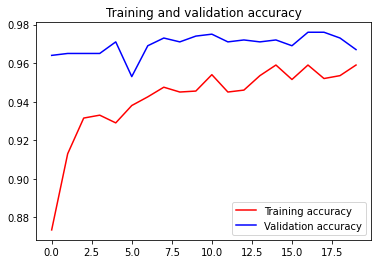

<Figure size 432x288 with 0 Axes>

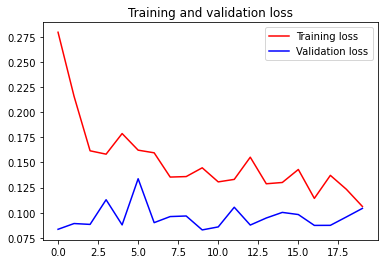

<Figure size 432x288 with 0 Axes>

In [49]:
# Evaluating Accuracy and Loss for the Model 
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [52]:
# Upload a file to test the model
uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes[0])
  
  if classes[0]>0:
    print(fn + " is a dog")
    
  else:
    print(fn + " is a cat")

Saving Test_image.jpg to Test_image.jpg
[0.]
Test_image.jpg is a cat
